In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

class Dental(Dataset):
  def __init__(self, csv_file,root_dir,transform=None) :
    super().__init__()
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index,1]))
    if self.transform:
       image = self.transform(image)
    return (image, y_label)

In [3]:
class_names = ['Impaction','Normal']

In [4]:
Image_size=300

In [5]:
#Over sampled
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torch.utils.data.dataloader import DataLoader
dataset = Dental(csv_file='/content/drive/MyDrive/Dental overS/Denanot - Copy.csv',
                  root_dir='/content/drive/MyDrive/Dental overS/Both',transform=v2.Compose([
v2.ToImage(),
#v2.CenterCrop(Image_size),
v2.RandomHorizontalFlip(p=0.5),
v2.ToDtype(torch.float32, scale=True),
v2.Normalize((0.4632, 0.4632, 0.4632), (0.2538, 0.2538, 0.2538))
]))
train_set, test_set= torch.utils.data.random_split(dataset,[882,220] )
train_loader= DataLoader(dataset=train_set,batch_size=16,shuffle=True,num_workers=2)
test_loader= DataLoader(dataset=test_set,batch_size=16,shuffle=True,num_workers=2)

In [6]:
#Original Resized
Dset = Dental(csv_file='/content/drive/MyDrive/Dental Res/dentAnnot0.csv',
                 root_dir='/content/drive/MyDrive/Dental Res/Both',transform=v2.Compose([
v2.ToImage(),
v2.RandomHorizontalFlip(p=0.5),
v2.ToDtype(torch.float32, scale=True),
#v2.CenterCrop(Image_size),
v2.Normalize((0.4659, 0.4659, 0.4659), (0.2540, 0.2540, 0.2540))
]))
Dtrain_set, Dtest_set= torch.utils.data.random_split(Dset,[500,213] )
Dtrain_loader= DataLoader(dataset=train_set,batch_size=16,shuffle=True,num_workers=2)
Dtest_loader= DataLoader(dataset=test_set,batch_size=16,shuffle=True,num_workers=2)

In [7]:
connected_model = nn.Sequential(
            nn.Linear(64800, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [8]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(66946946, [66355200, 1024, 524288, 512, 65536, 128, 256, 2])

In [9]:
first_model = nn.Sequential(
                nn.Linear(64800, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(33179138, [33177600, 512, 1024, 2])

In [11]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [12]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [13]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [14]:
img, _ = dataset[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 270, 500]), torch.Size([1, 16, 268, 498]))

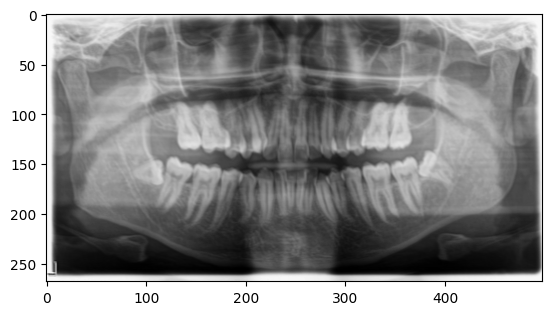

In [15]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 270, 500]), torch.Size([1, 1, 270, 500]))

In [17]:
with torch.no_grad():
     conv.bias.zero_()
with torch.no_grad():
     conv.weight.fill_(1.0 / 9.0)

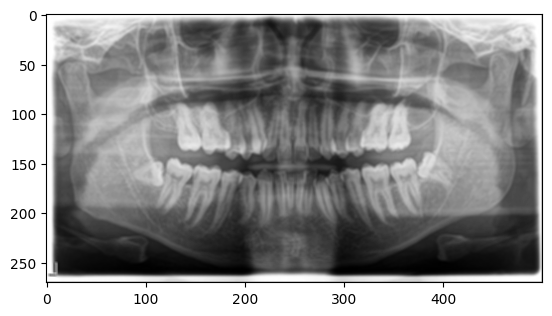

In [18]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
      conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                              [-1.0, 0.0, 1.0],
                              [-1.0, 0.0, 1.0]])
      conv.bias.zero_()

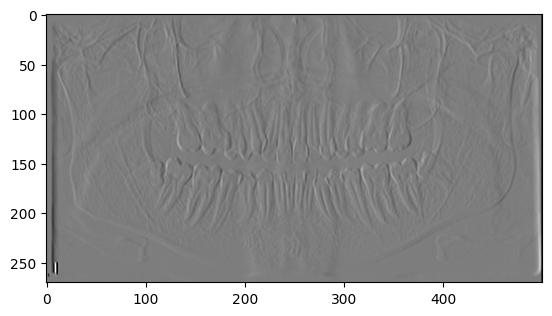

In [20]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [21]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 270, 500]), torch.Size([1, 3, 135, 250]))

In [22]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
nn.Conv2d(16, 8, kernel_size=3, padding=1),
nn.Tanh(),
nn.MaxPool2d(2),
# ...
nn.Linear(8 * 8 * 8, 32),
nn.Tanh(),
nn.Linear(32, 2))

In [23]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list


(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [24]:
##model(img.unsqueeze(0))

In [25]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
model = Net1()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [27]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(125*67*8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 125*67*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.2712,  0.1916]], grad_fn=<AddmmBackward0>)

In [29]:

'''import datetime
def training_loop(n_epochs, optimizer, model,loss_fn, train_loader):
   for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels in train_loader:
          imgs = imgs.to(torch.float)
          labels = labels.to(torch.float)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_train += loss.item()
      if epoch == 1 or epoch % 10 == 0:
         print('{} Epoch {}, Training loss {}'.format(
               datetime.datetime.now(), epoch,
               loss_train / len(train_loader))) '''

"import datetime\ndef training_loop(n_epochs, optimizer, model,loss_fn, train_loader):\n   for epoch in range(1, n_epochs + 1):\n      loss_train = 0.0\n      for imgs, labels in train_loader:\n          imgs = imgs.to(torch.float)\n          labels = labels.to(torch.float)\n          outputs = model(imgs)\n          loss = loss_fn(outputs, labels)\n          optimizer.zero_grad()\n          loss.backward()\n          optimizer.step()\n          loss_train += loss.item()\n      if epoch == 1 or epoch % 10 == 0:\n         print('{} Epoch {}, Training loss {}'.format(\n               datetime.datetime.now(), epoch,\n               loss_train / len(train_loader))) "

Training

In [30]:

'''
model = Net() #
optimizer = optim.SGD(model.parameters(), lr=1e-2) #
loss_fn = FocalLoss()
training_loop(
   n_epochs = 100,
   optimizer = optimizer,
   model = model,
   loss_fn = loss_fn,
   train_loader = train_loader,
)'''

'\nmodel = Net() #\noptimizer = optim.SGD(model.parameters(), lr=1e-2) #\nloss_fn = FocalLoss()\ntraining_loop(\n   n_epochs = 100,\n   optimizer = optimizer,\n   model = model,\n   loss_fn = loss_fn,\n   train_loader = train_loader,\n)'

In [31]:
'''
def validate(model, train_loader, test_loader):
       for name, loader in [("train", train_loader), ("val", test_loader)]:
             correct = 0
             total = 0
             with torch.no_grad():
                 for imgs, labels in loader:
                          imgs, labels = imgs.to(device), labels.to(device)
                          outputs = model(imgs)
                          _, predicted = torch.max(outputs, dim=1)
                          total += labels.shape[0]
                          correct += int((predicted == labels).sum())
             print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, test_loader)
'''

'\ndef validate(model, train_loader, test_loader):\n       for name, loader in [("train", train_loader), ("val", test_loader)]:\n             correct = 0\n             total = 0\n             with torch.no_grad():\n                 for imgs, labels in loader:\n                          imgs, labels = imgs.to(device), labels.to(device)\n                          outputs = model(imgs)\n                          _, predicted = torch.max(outputs, dim=1)\n                          total += labels.shape[0]\n                          correct += int((predicted == labels).sum())\n             print("Accuracy {}: {:.2f}".format(name , correct / total))\nvalidate(model, train_loader, test_loader)\n'

In [32]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Dental_F_res/' + 'Naive_CNN2.pt')

In [33]:
#loaded_model = Net()
#loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Dental_F_res/' + 'Naive_CNN2.pt'))


In [34]:
device = (torch.device('cuda') if torch.cuda.is_available()
                        else torch.device('cpu'))
print(f"Training on device {device}.")


Training on device cuda.


In [35]:
## Training on gpu
'''
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
     for epoch in range(1, n_epochs + 1):
          loss_train = 0.0
          for imgs, labels in train_loader:
               imgs = imgs.to(device=device)
               imgs = imgs.to(torch.float)
               labels = labels.to(device=device)
               outputs = model(imgs)
               loss = loss_fn(outputs, labels)
               optimizer.zero_grad()
               loss.backward()
               optimizer.step()
               loss_train += loss.item()
          if epoch == 1 or epoch % 10 == 0:
               print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(), epoch,
                    loss_train / len(train_loader)))
                    '''

"\nimport datetime\ndef training_loop(n_epochs, optimizer, model, loss_fn, train_loader):\n     for epoch in range(1, n_epochs + 1):\n          loss_train = 0.0\n          for imgs, labels in train_loader:\n               imgs = imgs.to(device=device)\n               imgs = imgs.to(torch.float)\n               labels = labels.to(device=device)\n               outputs = model(imgs)\n               loss = loss_fn(outputs, labels)\n               optimizer.zero_grad()\n               loss.backward()\n               optimizer.step()\n               loss_train += loss.item()\n          if epoch == 1 or epoch % 10 == 0:\n               print('{} Epoch {}, Training loss {}'.format(\n                    datetime.datetime.now(), epoch,\n                    loss_train / len(train_loader)))\n                    "

In [36]:
'''
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)
'''

'\nmodel = Net().to(device=device)\noptimizer = optim.SGD(model.parameters(), lr=1e-2)\nloss_fn = nn.CrossEntropyLoss()\ntraining_loop(\nn_epochs = 100,\noptimizer = optimizer,\nmodel = model,\nloss_fn = loss_fn,\ntrain_loader = train_loader,\n)\n'

In [37]:
'''
def validate(model, train_loader, test_loader):
       for name, loader in [("train", train_loader), ("val", test_loader)]:
             correct = 0
             total = 0
             with torch.no_grad():
                 for imgs, labels in loader:
                          imgs, labels = imgs.to(device), labels.to(device)
                          outputs = model(imgs)
                          _, predicted = torch.max(outputs, dim=1)
                          total += labels.shape[0]
                          correct += int((predicted == labels).sum())
             print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, test_loader)
'''

'\ndef validate(model, train_loader, test_loader):\n       for name, loader in [("train", train_loader), ("val", test_loader)]:\n             correct = 0\n             total = 0\n             with torch.no_grad():\n                 for imgs, labels in loader:\n                          imgs, labels = imgs.to(device), labels.to(device)\n                          outputs = model(imgs)\n                          _, predicted = torch.max(outputs, dim=1)\n                          total += labels.shape[0]\n                          correct += int((predicted == labels).sum())\n             print("Accuracy {}: {:.2f}".format(name , correct / total))\nvalidate(model, train_loader, test_loader)\n'

In [38]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Dental_F_res/' + 'Naive_CNN3gpu.pt')

Regularization


In [39]:
import datetime
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                                   train_loader):
       for epoch in range(1, n_epochs + 1):
            loss_train = 0.0
            for imgs, labels in train_loader:
                        imgs = imgs.to(device=device)
                        imgs = imgs.to(torch.float)
                        labels = labels.to(device=device)
                        outputs = model(imgs)
                        loss = loss_fn(outputs, labels)
                        l2_lambda = 0.0
                        l2_norm = sum(p.pow(2.0).sum()
                                    for p in model.parameters())
                        loss = loss + l2_lambda * l2_norm
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()
            if epoch == 1 or epoch % 10 == 0:
                        print('{} Epoch {}, Training loss {}'.format(
                                    datetime.datetime.now(), epoch,
                                    loss_train / len(train_loader)))

Dropuout

In [40]:
class NetDropout(nn.Module):
     def __init__(self, n_chans1=32):
          super().__init__()
          self.n_chans1 = n_chans1
          self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
          self.conv1_dropout = nn.Dropout2d(p=0.4)
          self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
          padding=1)
          self.conv2_dropout = nn.Dropout2d(p=0.4)
          self.fc1 = nn.Linear(125*67 * n_chans1 // 2, 32)
          self.fc2 = nn.Linear(32, 2)
     def forward(self, x):
          out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
          out = self.conv1_dropout(out)
          out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
          out = self.conv2_dropout(out)
          out = out.view(-1, 125*67 * self.n_chans1 // 2)
          out = torch.tanh(self.fc1(out))
          out = self.fc2(out)
          return out

Batch Normaliztion

In [41]:
class NetBatchNorm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
    padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
    self.fc1 = nn.Linear(125*67 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)
  def forward(self, x):
    out = self.conv1_batchnorm(self.conv1(x))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = self.conv2_batchnorm(self.conv2(out))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = out.view(-1, 125*67 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

Residual Connection

In [42]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
        padding=1, bias=False) # The BatchNorm layer would cancel the effect of bias, so it is customarily left out.
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, #Uses custom initializations , . kaiming_normal_ initializes with normal random elements with standard deviation as computed in the ResNet paper. The batch norm is initialized to produce output distributions that initially have 0 mean and 0.5 variance.
        nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [43]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(125*67 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 125*67 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
'''model = NetResDeep().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)'''

'model = NetResDeep().to(device=device)\nmodel.train()\noptimizer = optim.SGD(model.parameters(), lr=3e-4)\nloss_fn = nn.CrossEntropyLoss()\ntraining_loop_l2reg(\nn_epochs = 100,\noptimizer = optimizer,\nmodel = model,\nloss_fn = loss_fn,\ntrain_loader = train_loader,\n)'

In [45]:

model.eval()
def validate(model, train_loader, test_loader):
       for name, loader in [("train", train_loader), ("val", test_loader)]:
             correct = 0
             total = 0
             with torch.no_grad():
                 for imgs, labels in loader:
                          imgs, labels = imgs.to(device), labels.to(device)
                          outputs = model(imgs)
                          _, predicted = torch.max(outputs, dim=1)
                          total += labels.shape[0]
                          correct += int((predicted == labels).sum())
             print("Accuracy {}: {:.2f}".format(name , correct / total))


In [46]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Dental_F_res/' + 'ResudaldeepCNN3gpu.pt')

# **Original Dataset **

Simple Convnet

In [47]:

print('Training..')
model = Net().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = Dtrain_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, Dtrain_loader, Dtest_loader)
print('Validation Done')

Training..
2023-11-16 10:22:24.266230 Epoch 1, Training loss 0.6851450715746198
2023-11-16 10:23:23.798117 Epoch 10, Training loss 0.4396471663245133
2023-11-16 10:24:28.092640 Epoch 20, Training loss 0.04237882217525372
2023-11-16 10:25:32.064943 Epoch 30, Training loss 0.006927904835070616
2023-11-16 10:26:36.417171 Epoch 40, Training loss 0.0033541486523712854
2023-11-16 10:27:41.660563 Epoch 50, Training loss 0.0022736099937381887
2023-11-16 10:28:47.522913 Epoch 60, Training loss 0.0016358811231579498
2023-11-16 10:29:53.353285 Epoch 70, Training loss 0.0013228895518945397
2023-11-16 10:30:58.578407 Epoch 80, Training loss 0.0010605479183141142
2023-11-16 10:32:03.836232 Epoch 90, Training loss 0.0008990978785732295
2023-11-16 10:33:07.965665 Epoch 100, Training loss 0.0007542323468702047
Training done
Validating...
Accuracy train: 1.00
Accuracy val: 0.97
Validation Done


Conv With Droupout

In [48]:
print('Training..')
model = NetDropout().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = Dtrain_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, Dtrain_loader, Dtest_loader)
print('Validation Done')

Training..
2023-11-16 10:34:25.356162 Epoch 1, Training loss 0.7223727437002319
2023-11-16 10:35:25.585761 Epoch 10, Training loss 0.6072243143405233
2023-11-16 10:36:31.831491 Epoch 20, Training loss 0.600006774600063
2023-11-16 10:37:38.653477 Epoch 30, Training loss 0.6046484687498638
2023-11-16 10:38:44.453259 Epoch 40, Training loss 0.6038492263427803
2023-11-16 10:39:49.853474 Epoch 50, Training loss 0.5682575537690094
2023-11-16 10:40:55.844163 Epoch 60, Training loss 0.5647180995770863
2023-11-16 10:42:02.244746 Epoch 70, Training loss 0.5752959203507219
2023-11-16 10:43:08.406957 Epoch 80, Training loss 0.5643584973045758
2023-11-16 10:44:14.528854 Epoch 90, Training loss 0.5811506174504757
2023-11-16 10:45:21.308993 Epoch 100, Training loss 0.5649405276136739
Training done
Validating...
Accuracy train: 0.75
Accuracy val: 0.72
Validation Done


Conv With BatchNorm

In [49]:
print('Training..')
model = NetBatchNorm().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = Dtrain_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, Dtrain_loader, Dtest_loader)
print('Validation Done')

Training..
2023-11-16 10:45:36.640360 Epoch 1, Training loss 0.7864813442741122
2023-11-16 10:46:39.513712 Epoch 10, Training loss 0.6503351139170783
2023-11-16 10:47:47.383102 Epoch 20, Training loss 0.577956243285111
2023-11-16 10:48:55.519559 Epoch 30, Training loss 0.47949717726026264
2023-11-16 10:50:04.144963 Epoch 40, Training loss 0.38762687652238775
2023-11-16 10:51:13.141706 Epoch 50, Training loss 0.1688646974175104
2023-11-16 10:52:21.380944 Epoch 60, Training loss 0.1941550299525261
2023-11-16 10:53:29.847216 Epoch 70, Training loss 0.0035877451508505537
2023-11-16 10:54:38.520251 Epoch 80, Training loss 0.0017056876625117315
2023-11-16 10:55:47.023541 Epoch 90, Training loss 0.0012842381204661382
2023-11-16 10:56:55.219149 Epoch 100, Training loss 0.0010462441288317287
Training done
Validating...
Accuracy train: 1.00
Accuracy val: 0.98
Validation Done


Residual Network

In [50]:
print('Training..')
model = NetResDeep().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = Dtrain_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, Dtrain_loader, Dtest_loader)
print('Validation Done')

Training..
2023-11-16 10:57:17.920475 Epoch 1, Training loss 0.9272628192390714
2023-11-16 10:59:20.233872 Epoch 10, Training loss 0.5631300482366767
2023-11-16 11:01:36.194576 Epoch 20, Training loss 0.5101251612816539
2023-11-16 11:03:52.237279 Epoch 30, Training loss 0.38745077579681364
2023-11-16 11:06:08.469897 Epoch 40, Training loss 0.3928101062774658
2023-11-16 11:08:24.376320 Epoch 50, Training loss 0.18842231003301485
2023-11-16 11:10:40.481634 Epoch 60, Training loss 0.1920181341868426
2023-11-16 11:12:56.563657 Epoch 70, Training loss 0.056030198565817306
2023-11-16 11:15:12.126916 Epoch 80, Training loss 0.037438151243674965
2023-11-16 11:17:27.695007 Epoch 90, Training loss 0.02110925694328866
2023-11-16 11:19:43.353201 Epoch 100, Training loss 0.015122992152880346
Training done
Validating...
Accuracy train: 0.86
Accuracy val: 0.72
Validation Done


# **Oversampled Dataset**

Simple Convenet

In [51]:
print('Training..')
model = Net().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = train_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, train_loader, test_loader)
print('Validation Done')

Training..
2023-11-16 11:19:58.883257 Epoch 1, Training loss 0.7155450082251004
2023-11-16 11:20:56.341638 Epoch 10, Training loss 0.47677501450691906
2023-11-16 11:22:00.801896 Epoch 20, Training loss 0.6028320310371262
2023-11-16 11:23:04.782956 Epoch 30, Training loss 0.012458853947464377
2023-11-16 11:24:08.668451 Epoch 40, Training loss 0.0047668957766810694
2023-11-16 11:25:13.250128 Epoch 50, Training loss 0.0027337810086984454
2023-11-16 11:26:17.955808 Epoch 60, Training loss 0.0019512050452509097
2023-11-16 11:27:22.719203 Epoch 70, Training loss 0.0014807759767531284
2023-11-16 11:28:24.973189 Epoch 80, Training loss 0.0012070672725842866
2023-11-16 11:29:28.236095 Epoch 90, Training loss 0.0009983853389193037
2023-11-16 11:30:32.659613 Epoch 100, Training loss 0.0008706135117141198
Training done
Validating...
Accuracy train: 1.00
Accuracy val: 0.98
Validation Done


Convenet With Droupout

In [52]:
print('Training..')
model = NetDropout().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = train_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, train_loader, test_loader)
print('Validation Done')

Training..
2023-11-16 11:30:47.266684 Epoch 1, Training loss 0.742097981274128
2023-11-16 11:31:46.471317 Epoch 10, Training loss 0.6099863217345306
2023-11-16 11:32:51.726884 Epoch 20, Training loss 0.5963733313339097
2023-11-16 11:33:56.540404 Epoch 30, Training loss 0.5668359441416604
2023-11-16 11:35:01.790032 Epoch 40, Training loss 0.5715747778969151
2023-11-16 11:36:07.011929 Epoch 50, Training loss 0.5861169839543956
2023-11-16 11:37:12.217743 Epoch 60, Training loss 0.6096171092774186
2023-11-16 11:38:17.293401 Epoch 70, Training loss 0.5738713193152633
2023-11-16 11:39:22.155109 Epoch 80, Training loss 0.5785178121711526
2023-11-16 11:40:26.726265 Epoch 90, Training loss 0.5393535558666501
2023-11-16 11:41:31.881580 Epoch 100, Training loss 0.5229088637445655
Training done
Validating...
Accuracy train: 0.70
Accuracy val: 0.65
Validation Done


Convnet with Batchnorm

In [54]:

print('Training..')
model = NetBatchNorm().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = train_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, train_loader, test_loader)
print('Validation Done')

Training..
2023-11-16 11:46:11.778376 Epoch 1, Training loss 0.7078662078295436
2023-11-16 11:47:17.517395 Epoch 10, Training loss 0.5901428216270038
2023-11-16 11:48:26.884024 Epoch 20, Training loss 0.5592823001955237
2023-11-16 11:49:36.313292 Epoch 30, Training loss 0.5163415947130748
2023-11-16 11:50:45.450878 Epoch 40, Training loss 0.3104419092248593
2023-11-16 11:51:54.564134 Epoch 50, Training loss 0.028184291948231736
2023-11-16 11:53:04.985939 Epoch 60, Training loss 0.0024215554606468815
2023-11-16 11:54:15.260092 Epoch 70, Training loss 0.0015877674211099344
2023-11-16 11:55:30.447143 Epoch 80, Training loss 0.0011449806916061789
2023-11-16 11:56:47.565012 Epoch 90, Training loss 0.0009535404351481702
2023-11-16 11:58:02.779874 Epoch 100, Training loss 0.0007993406678516683
Training done
Validating...
Accuracy train: 1.00
Accuracy val: 0.98
Validation Done


Residual Network

In [57]:
print('Training..')
model = NetResDeep().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs = 100,optimizer = optimizer,model = model,loss_fn = loss_fn,
                    train_loader = train_loader,)
print('Training done')
print('Validating...')
model.eval()
validate(model, train_loader, test_loader)
print('Validation Done')

Training..
2023-11-16 12:50:59.776902 Epoch 1, Training loss 0.7764001275811877
2023-11-16 12:53:04.394807 Epoch 10, Training loss 0.6327159447329385
2023-11-16 12:55:22.836383 Epoch 20, Training loss 0.48598057138068335
2023-11-16 12:57:41.192895 Epoch 30, Training loss 0.37411718017288614
2023-11-16 13:00:00.056003 Epoch 40, Training loss 0.2866715490152793
2023-11-16 13:02:18.262396 Epoch 50, Training loss 0.11555329630417484
2023-11-16 13:04:36.070275 Epoch 60, Training loss 0.15470381387110269
2023-11-16 13:06:54.586704 Epoch 70, Training loss 0.07699121461649026
2023-11-16 13:09:12.909588 Epoch 80, Training loss 0.030079291368435537
2023-11-16 13:11:31.288337 Epoch 90, Training loss 0.01451933612614604
2023-11-16 13:13:49.526420 Epoch 100, Training loss 0.010927378094493179
Training done
Validating...
Accuracy train: 0.59
Accuracy val: 0.60
Validation Done
